In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json

In [2]:
with open("./files_map.json", "r") as f:
    files_map = json.load(f)
# files_map

In [3]:
df = pd.read_csv("./data/clean/wealth_data.csv")
df["iso2"] = df["folder"].str[0:2]

wealth = pd.DataFrame(df.groupby(["folder", "hv001"])["hv271"].mean()).reset_index()
wealth["geo_folder"] = wealth["folder"].map(files_map)
wealth["hv001"] = wealth["hv001"].astype(str)
wealth.head()
# df.head()

,folder,hv001,hv271,geo_folder
0,ALHR51DT,1,-60560.666667,ALGE51FL
1,ALHR51DT,2,-22933.450000,ALGE51FL
2,ALHR51DT,3,-53580.777778,ALGE51FL
3,ALHR51DT,4,-82308.789474,ALGE51FL
4,ALHR51DT,5,-103261.526316,ALGE51FL


In [4]:
gdf = gpd.read_file("./data/clean/shps/point_data.shp")
gdf = gdf.rename(columns = {"folder": "geo_folder"})
gdf["iso2"] = gdf["DHSID"].str[0:2]
gdf["buffer_size"] = -99
gdf["buffer_size"] = np.where(gdf['URBAN_RURA'] == "U", 2, gdf["buffer_size"])
gdf["buffer_size"] = np.where(gdf['URBAN_RURA'] == "R", 5, gdf["buffer_size"])
gdf["hv007"] = gdf["DHSYEAR"].astype(int).astype(str)
gdf["hv001"] = gdf["DHSCLUST"].astype(int).astype(str)
# gdf = gdf.rename(columns = {"DHSCC": "iso2_v2"})
gdf.head()

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geo_folder,geometry,iso2,buffer_size,hv007,hv001
0,TJ201200000001,TJ,2012.0,1.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,68.865018,9999.0,830.0,WGS84,TJGE61FL,POINT (68.86502 38.55115),TJ,2,2012,1
1,TJ201200000002,TJ,2012.0,2.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,68.834834,9999.0,831.0,WGS84,TJGE61FL,POINT (68.83483 38.56755),TJ,2,2012,2
2,TJ201200000003,TJ,2012.0,3.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,68.814258,9999.0,840.0,WGS84,TJGE61FL,POINT (68.81426 38.56332),TJ,2,2012,3
3,TJ201200000004,TJ,2012.0,4.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,68.823310,9999.0,823.0,WGS84,TJGE61FL,POINT (68.82331 38.55838),TJ,2,2012,4
4,TJ201200000005,TJ,2012.0,5.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,68.796493,9999.0,828.0,WGS84,TJGE61FL,POINT (68.79649 38.56642),TJ,2,2012,5


In [7]:
merged = pd.merge(gdf, wealth, on = ["geo_folder", "hv001"])
merged["n_points"] = -99
merged["n_points"] = np.where(merged['URBAN_RURA'] == "U", 10, merged["n_points"])
merged["n_points"] = np.where(merged['URBAN_RURA'] == "R", 20, merged["n_points"])
merged.head()

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,DATUM,geo_folder,geometry,iso2,buffer_size,hv007,hv001,folder,hv271,n_points
0,TJ201200000001,TJ,2012.0,1.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,WGS84,TJGE61FL,POINT (68.86502 38.55115),TJ,2,2012,1,TJHR61DT,145477.117647,10
1,TJ201200000002,TJ,2012.0,2.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,WGS84,TJGE61FL,POINT (68.83483 38.56755),TJ,2,2012,2,TJHR61DT,23204.764706,10
2,TJ201200000003,TJ,2012.0,3.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,WGS84,TJGE61FL,POINT (68.81426 38.56332),TJ,2,2012,3,TJHR61DT,-2363.333333,10
3,TJ201200000004,TJ,2012.0,4.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,WGS84,TJGE61FL,POINT (68.82331 38.55838),TJ,2,2012,4,TJHR61DT,135556.533333,10
4,TJ201200000005,TJ,2012.0,5.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,WGS84,TJGE61FL,POINT (68.79649 38.56642),TJ,2,2012,5,TJHR61DT,33137.900000,10


In [90]:
from shapely.geometry import Polygon, Point
import shapely
import pyproj
import utm

In [91]:
# wgs84 = pyproj.CRS('EPSG:4326')
# utm_proj_string = "+proj=utm +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"
# utm_proj = pyproj.CRS.from_proj4(utm_proj_string)
# projection = pyproj.Transformer.from_crs(wgs84, utm_proj, always_xy = True).transform
# projection_back = pyproj.Transformer.from_crs(utm_proj, wgs84, always_xy=True).transform

In [122]:
m = gpd.read_file("./data/clean/shps/wealth_points.shp")
m

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,DATUM,geo_folder,iso2,buffer_siz,hv007,hv001,folder,hv271,n_points,geometry
0,TJ201200000001,TJ,2012.0,1.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,WGS84,TJGE61FL,TJ,2,2012,1,TJHR61DT,145477.117647,10,POINT (68.86502 38.55115)
1,TJ201200000002,TJ,2012.0,2.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,WGS84,TJGE61FL,TJ,2,2012,2,TJHR61DT,23204.764706,10,POINT (68.83483 38.56755)
2,TJ201200000003,TJ,2012.0,3.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,WGS84,TJGE61FL,TJ,2,2012,3,TJHR61DT,-2363.333333,10,POINT (68.81426 38.56332)
3,TJ201200000004,TJ,2012.0,4.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,WGS84,TJGE61FL,TJ,2,2012,4,TJHR61DT,135556.533333,10,POINT (68.82331 38.55838)
4,TJ201200000005,TJ,2012.0,5.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,WGS84,TJGE61FL,TJ,2,2012,5,TJHR61DT,33137.900000,10,POINT (68.79649 38.56642)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86647,TJ201700000362,TJ,2017.0,362.0,TI,NULL,NULL,NULL,NULL,5.0,...,WGS84,TJGE71FL,TJ,5,2017,362,TJHR72DT,-65437.818182,20,POINT (71.65652 37.53273)
86648,TJ201700000363,TJ,2017.0,363.0,TI,NULL,NULL,NULL,NULL,5.0,...,WGS84,TJGE71FL,TJ,5,2017,363,TJHR72DT,-61389.333333,20,POINT (71.73990 37.61017)
86649,TJ201700000364,TJ,2017.0,364.0,TI,NULL,NULL,NULL,NULL,5.0,...,WGS84,TJGE71FL,TJ,5,2017,364,TJHR72DT,-83456.500000,20,POINT (71.82929 37.64777)
86650,TJ201700000365,TJ,2017.0,365.0,TI,NULL,NULL,NULL,NULL,5.0,...,WGS84,TJGE71FL,TJ,5,2017,365,TJHR72DT,-99577.545455,20,POINT (72.05069 37.75604)


In [116]:
merged[0:1000].to_file("test1.shp")

/tmp/ipykernel_107040/2559911108.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged[0:1000].to_file("test1.shp")


In [114]:
smol = merged[0:1000]

# smol["test1"], smol["test2"] = 0,0


def test(x1, x2, x3):
    x, y = x1.x, x1.y
    x, y, zone, hem = utm.from_latlon(y, x)
    wgs84 = pyproj.CRS('EPSG:4326')
    utm_proj = pyproj.CRS.from_proj4(f"+proj=utm +datum=WGS84 +units=m +zone={str(zone)} +no_defs +ellps=WGS84 +towgs84=0,0,0")
    projection_back = pyproj.Transformer.from_crs(utm_proj, wgs84, always_xy=True).transform
    p = Point(x, y)
    p = gpd.GeoSeries([p]).buffer(x3 * 1000, cap_style = 3)
#     p = gpd.GeoSeries([p]).buffer(100, cap_style = 3)
    box = Polygon(shapely.ops.transform(projection_back, p[0]))
    return [box, zone, hem]
    
smol["test1"] = smol.apply(lambda x: test(x.geometry, x.DHSCC, x.buffer_size), axis=1)
smol[["box", 'utm_zone', "hemisphere"]] = pd.DataFrame(smol.test1.tolist(), index= smol.index)
smol = smol.drop(["test1", "geometry"], axis = 1)
# smol.geometry = smol.box
smol = gpd.GeoDataFrame(smol, geometry = "box")
smol.head()

/opt/conda/envs/caoe/lib/python3.9/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/caoe/lib/python3.9/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/caoe/lib/python3.9/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,iso2,buffer_size,hv007,hv001,folder,hv271,n_points,box,utm_zone,hemisphere
0,TJ201200000001,TJ,2012.0,1.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,TJ,2,2012,1,TJHR61DT,145477.117647,10,"POLYGON ((68.88794 38.56920, 68.88800 38.53315...",42,S
1,TJ201200000002,TJ,2012.0,2.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,TJ,2,2012,2,TJHR61DT,23204.764706,10,"POLYGON ((68.85776 38.58560, 68.85783 38.54955...",42,S
2,TJ201200000003,TJ,2012.0,3.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,TJ,2,2012,3,TJHR61DT,-2363.333333,10,"POLYGON ((68.83717 38.58138, 68.83726 38.54533...",42,S
3,TJ201200000004,TJ,2012.0,4.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,TJ,2,2012,4,TJHR61DT,135556.533333,10,"POLYGON ((68.84623 38.57644, 68.84630 38.54039...",42,S
4,TJ201200000005,TJ,2012.0,5.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,TJ,2,2012,5,TJHR61DT,33137.900000,10,"POLYGON ((68.81941 38.58449, 68.81950 38.54844...",42,S


In [ ]:
"./data/clean/shps/wealth_buffers.shp"

In [119]:
print(gpd.read_file("./test1_buffers.shp").geometry[0])

POLYGON ((68.88126560036783 38.563854309934285, 68.88125985973018 38.53844611737734, 68.84877646767113 38.53844611737734, 68.84877072703348 38.563854309934285, 68.88126560036783 38.563854309934285))


In [110]:
print(smol.geometry[0])

POLYGON ((68.88794271334848 38.569199590204015, 68.8879986513887 38.53315145425184, 68.84210507451218 38.53309856177491, 68.84202621554692 38.56914662984088, 68.88794271334848 38.569199590204015))


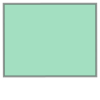

In [111]:
smol.geometry[0]

<AxesSubplot:>

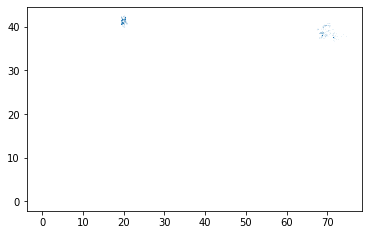

In [121]:
gpd.read_file("./test1_buffers.shp").plot()

<AxesSubplot:>

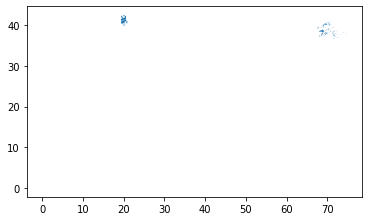

In [120]:
smol.plot()

In [115]:
smol.to_file("smol5.shp")

/tmp/ipykernel_107040/2487609241.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  smol.to_file("smol5.shp")


In [19]:
merged.shape

(86652, 29)

In [8]:
merged["n_points"].sum()

1436480

In [9]:
# merged.to_file("./data/clean/shps/wealth_points.shp")

/tmp/ipykernel_107040/477662325.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged.to_file("./data/clean/shps/wealth_points.shp")


In [129]:
def gen_random_points(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return list(zip(x, y))

In [130]:
gdf.head()

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,iso2,buffer_siz,hv007,hv001,folder,hv271,n_points,utm_zone,hemisphere,geometry
0,TJ201200000001,TJ,2012.0,1.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,TJ,2,2012,1,TJHR61DT,145477.117647,10,42,S,"POLYGON ((68.88794 38.56920, 68.88800 38.53315..."
1,TJ201200000002,TJ,2012.0,2.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,TJ,2,2012,2,TJHR61DT,23204.764706,10,42,S,"POLYGON ((68.85776 38.58560, 68.85783 38.54955..."
2,TJ201200000003,TJ,2012.0,3.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,TJ,2,2012,3,TJHR61DT,-2363.333333,10,42,S,"POLYGON ((68.83717 38.58138, 68.83726 38.54533..."
3,TJ201200000004,TJ,2012.0,4.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,TJ,2,2012,4,TJHR61DT,135556.533333,10,42,S,"POLYGON ((68.84623 38.57644, 68.84630 38.54039..."
4,TJ201200000005,TJ,2012.0,5.0,TI,TI04,Dushanbe,NULL,NULL,1.0,...,TJ,2,2012,5,TJHR61DT,33137.900000,10,42,S,"POLYGON ((68.81941 38.58449, 68.81950 38.54844..."


In [140]:
gdf = gpd.read_file("./buffer_test.shp")
gdf['random_points'] = gdf.apply(lambda x: gen_random_points(x['geometry'], x['n_points']), axis = 1)
gdf = gdf[["DHSID", "DHSYEAR", "DHSCLUST", "folder", "buffer_siz", "hv001", "hv271", "geometry", "n_points", "random_points"]]
gdf = gdf.explode('random_points')
gdf["val"] = 1
gdf['cumsum'] = gdf[["DHSID", 'val']].groupby('DHSID').cumsum()
gdf.head()

,DHSID,DHSYEAR,DHSCLUST,folder,buffer_siz,hv001,hv271,geometry,n_points,random_points,val,cumsum
0,TJ201200000001,2012.0,1.0,TJHR61DT,2,1,145477.117647,"POLYGON ((68.88794 38.56920, 68.88800 38.53315...",10,"(68.88441638304005, 38.567692873695165)",1,1
0,TJ201200000001,2012.0,1.0,TJHR61DT,2,1,145477.117647,"POLYGON ((68.88794 38.56920, 68.88800 38.53315...",10,"(68.8783454242658, 38.55028121963481)",1,2
0,TJ201200000001,2012.0,1.0,TJHR61DT,2,1,145477.117647,"POLYGON ((68.88794 38.56920, 68.88800 38.53315...",10,"(68.88407951667685, 38.55220744435085)",1,3
0,TJ201200000001,2012.0,1.0,TJHR61DT,2,1,145477.117647,"POLYGON ((68.88794 38.56920, 68.88800 38.53315...",10,"(68.86935870776232, 38.53738498527151)",1,4
0,TJ201200000001,2012.0,1.0,TJHR61DT,2,1,145477.117647,"POLYGON ((68.88794 38.56920, 68.88800 38.53315...",10,"(68.86723978234613, 38.554616475587466)",1,5
